In [1]:
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from sklearn.model_selection import train_test_split
import torchvision as tv
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms




device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


dataset=datasets.ImageFolder(root="/kaggle/input/flowers/flowers")


def correct_format(dataset):
    dataset_correct=[]
    
    for img,label in dataset:
         dataset_correct.append((img, dataset.classes[label]))
        
    dataset_df= pd.DataFrame(dataset_correct, columns=["image","label"])
    
    return dataset_df
    
    
dataset_df=correct_format(dataset)

dataset_df.head()


True


,image,label
0,<PIL.Image.Image image mode=RGB size=256x256 a...,astilbe
1,<PIL.Image.Image image mode=RGB size=256x256 a...,astilbe
2,<PIL.Image.Image image mode=RGB size=256x256 a...,astilbe
3,<PIL.Image.Image image mode=RGB size=256x256 a...,astilbe
4,<PIL.Image.Image image mode=RGB size=256x256 a...,astilbe


In [2]:

counts=dataset_df['label'].value_counts()
counts


label
iris                1054
dandelion           1052
tulip               1048
magnolia            1048
coreopsis           1047
sunflower           1027
california_poppy    1022
black_eyed_susan    1000
rose                 999
water_lily           982
common_daisy         980
calendula            978
daffodil             970
carnation            923
bellflower           873
astilbe              737
Name: count, dtype: int64

In [3]:
some_labels=["dandelion","tulip","rose","sunflower"]

filtered_df=dataset_df[dataset_df["label"].isin(some_labels)]

In [4]:
counts=filtered_df["label"].value_counts()
counts

final_df=pd.DataFrame()

for label in filtered_df["label"].unique():
    label_df=filtered_df[filtered_df["label"]==label]
    label_df=label_df.sample(n=700, replace=True)
    final_df=pd.concat([final_df,label_df], ignore_index=True)

counts=final_df["label"].value_counts()
counts

label
dandelion    700
rose         700
sunflower    700
tulip        700
Name: count, dtype: int64

In [19]:
test_transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(246),
    transforms.ToTensor(),
   
])
train_transform=transforms.Compose([
    transforms.CenterCrop(246),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(),
 
    

    
])

In [20]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
class DataFrameImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        self.label2idx = {label: idx for idx, label in enumerate(sorted(dataframe['label'].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['image']       # Get image file path
        label_name = self.df.iloc[idx]['label']    # Get label name (e.g., 'rose')
        label_idx = self.label2idx[label_name]      # Convert label to number (e.g., 'rose' → 2)

        image = image.convert('RGB')  # Load image using PIL

        if self.transform:
            image = self.transform(image)

        return image, label_idx



train_df,valid_df=train_test_split(final_df,                    # your full DataFrame
    test_size=0.2,         # 20% for validation, 80% for training
    stratify=final_df['label'],  # optional: keeps class distribution balanced
    random_state=42   )
test_df,valid_df=train_test_split(valid_df,                    # your full DataFrame
    test_size=0.5,         # 20% for validation, 80% for training
    stratify=valid_df['label'],  # optional: keeps class distribution balanced
    random_state=42   )

train_set = DataFrameImageDataset(train_df, transform=train_transform)
val_set   = DataFrameImageDataset(valid_df, transform=test_transform)
test_set   = DataFrameImageDataset(test_df,transform=test_transform)

train_load=DataLoader(train_set, batch_size=24,shuffle=True)
valid_load=DataLoader(val_set, batch_size=24, shuffle=False)
test_load=DataLoader(test_set, batch_size=24, shuffle=False)


In [2]:
model=nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,stride=1,padding=0),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    nn.Dropout(0.1),
    
    nn.Conv2d(16,32,kernel_size=3,stride=1,padding=0),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    nn.Dropout(0.5),
   
    nn.Conv2d(32,64,kernel_size=3,stride=1,padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
   
 
    
    nn.Flatten(),
    nn.Linear(64*29*29,128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128,4),
    nn.BatchNorm1d(4),
    nn.ReLU(),
    
 
    


)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.5, inplace=False)
  (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=53824, out_features=128, bias=True)
  (15): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=128, o

In [22]:
measuring_loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=2,factor=0.5,verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
def train(model, train_load):
  
      model.train()
      loss=0
      total_loss=0
      correct=0
      total_images_per_batch=0
      for image, label in train_load:
            image=image.to(device)
            label=label.to(device)
          
            optimizer.zero_grad()
          
            output=model(image)

            loss=measuring_loss(output,label)
    
            loss.backward()
          
            optimizer.step()
           
            total_loss+=loss.item()
          
            pred=output.argmax(dim=1)
            correct+=(pred==label).sum().item()
          
            total_images_per_batch+=label.size(0)

    
      avg_train_loss=(total_loss/len(train_load))
      accuracy_train=(100*correct/total_images_per_batch)
    
          
       
      return avg_train_loss,accuracy_train

def valid(model, valid_load):
    model.eval()
   
    loss=0
    total_loss=0
    correct=0
    total_images_per_batch=0
      
    with torch.no_grad():
        for img,label in valid_load:
            
            img=img.to(device)
            label=label.to(device)
            
            output=model(img)
            
            loss=measuring_loss(output,label)
            
            total_loss+=loss.item()
            
            pred=output.argmax(dim=1)
            correct+=(pred==label).sum().item()
            
            total_images_per_batch+=label.size(0)
            
        avg_valid_loss=(total_loss/len(valid_load))
        accuracy_valid=(100*correct/total_images_per_batch)
            
    return avg_valid_loss,accuracy_valid

 

    

In [24]:
train_losses,valid_losses=[],[]
train_accs,valid_accs=[],[]
epochs=20
for epoch in range(epochs):
    train_loss,train_acc=train(model,train_load)
    valid_loss,valid_acc=valid(model,valid_load)
    scheduler.step(valid_loss)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    print(f"Epoch: {epoch+1}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_acc :.6f} % ")
    print(f"Valid Loss: {valid_loss:.6f} | Valid Accuracy: {valid_acc :.6f} % ")
    
    

Epoch: 1
Train Loss: 0.884247 | Train Accuracy: 72.901786 % 
Valid Loss: 0.973507 | Valid Accuracy: 66.071429 % 
Epoch: 2
Train Loss: 0.720379 | Train Accuracy: 81.026786 % 
Valid Loss: 0.908066 | Valid Accuracy: 63.571429 % 
Epoch: 3
Train Loss: 0.638295 | Train Accuracy: 84.285714 % 
Valid Loss: 0.745587 | Valid Accuracy: 75.357143 % 
Epoch: 4
Train Loss: 0.575273 | Train Accuracy: 86.071429 % 
Valid Loss: 0.734749 | Valid Accuracy: 76.428571 % 
Epoch: 5
Train Loss: 0.505952 | Train Accuracy: 88.482143 % 
Valid Loss: 0.573719 | Valid Accuracy: 84.285714 % 
Epoch: 6
Train Loss: 0.462611 | Train Accuracy: 89.687500 % 
Valid Loss: 0.585090 | Valid Accuracy: 85.714286 % 
Epoch: 7
Train Loss: 0.410722 | Train Accuracy: 91.875000 % 
Valid Loss: 0.541641 | Valid Accuracy: 86.071429 % 
Epoch: 8
Train Loss: 0.379279 | Train Accuracy: 92.500000 % 
Valid Loss: 0.456427 | Valid Accuracy: 88.571429 % 
Epoch: 9
Train Loss: 0.343785 | Train Accuracy: 93.660714 % 
Valid Loss: 0.495357 | Valid Accura

In [1]:

torch.save(model, 'model.pt')



NameError: name 'torch' is not defined

In [ ]:
## Load the entire model (no need to redefine architecture)

# model = torch.load('model.pt')
# model.eval() 

## Set to eval mode

In [30]:
os.listdir()

['model.pt', 'flower_model.pth', '.virtual_documents']

In [26]:
idx2label={v:k for k,v in test_set.label2idx.items()} #reverse dict.

 Test Example 1


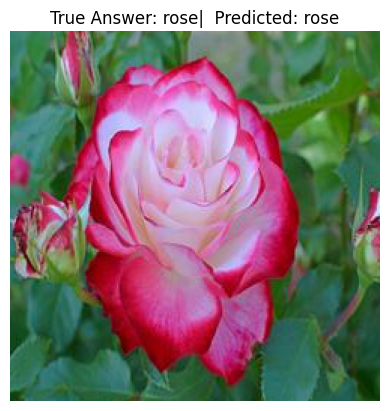

 Test Example 2


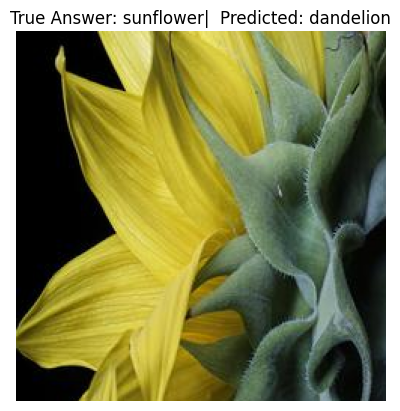

 Test Example 3


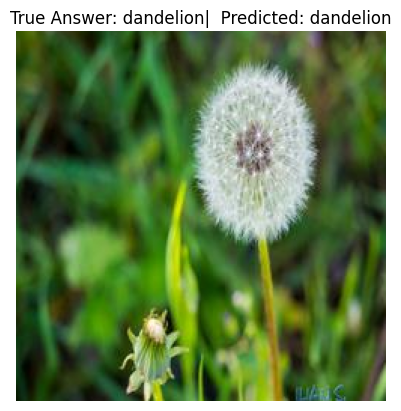

 Test Example 4


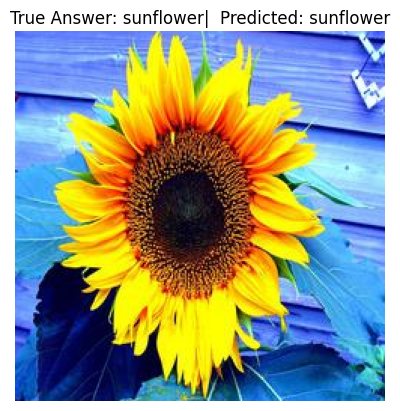

 Test Example 5


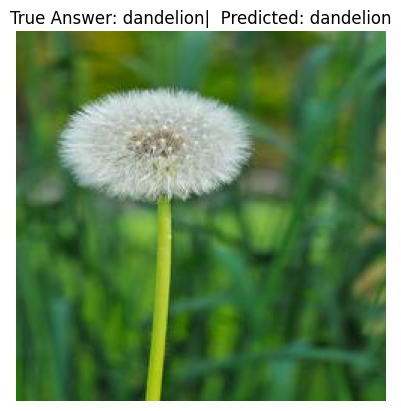

 Test Example 6


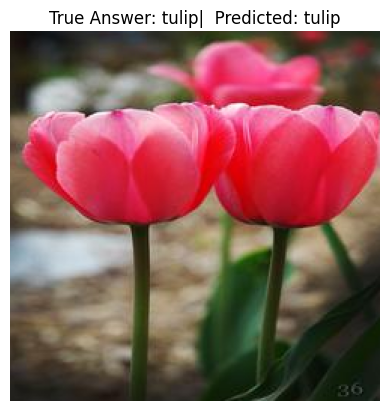

 Test Example 7


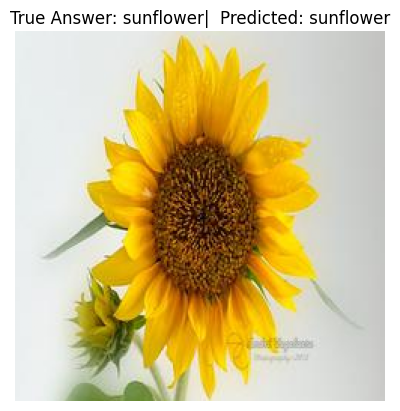

 Test Example 8


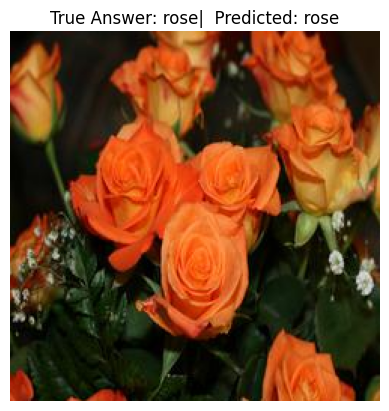

 Test Example 9


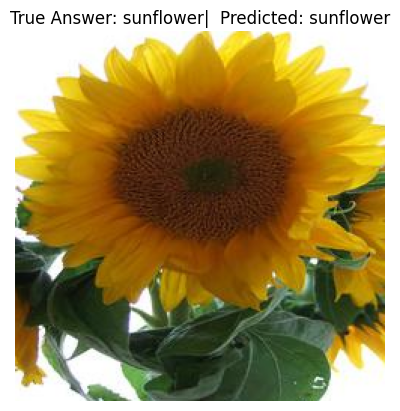

 Test Example 10


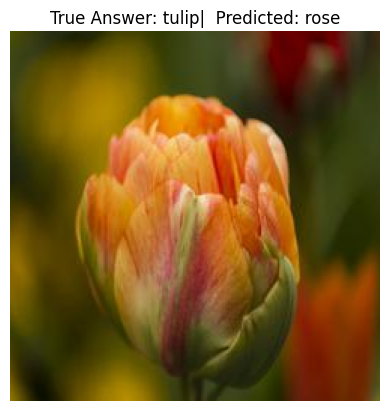

In [27]:

#testing
model.eval()
for i in range(10):
    print(f" Test Example {i+1}")
    img_tensor,label_num=test_set[i]

    img_tensor=img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output_prob=model(img_tensor)
        output_pred=output_prob.argmax(dim=1).item()
        output_label=idx2label[output_pred]
        true_label=idx2label[label_num]

        img_tensor=img_tensor.squeeze(0).to(device)
        img=img_tensor.permute(1,2,0)
        img=img.cpu().numpy()
        plt.imshow(img)
        plt.title(f"True Answer: {true_label}|  Predicted: {output_label}")
        plt.axis('off')
        plt.show()

In [6]:
import torch
import torch.nn as nn
model=nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,stride=1,padding=0),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    nn.Dropout(0.1),
    
    nn.Conv2d(16,32,kernel_size=3,stride=1,padding=0),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    nn.Dropout(0.5),
   
    nn.Conv2d(32,64,kernel_size=3,stride=1,padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
   
 
    
    nn.Flatten(),
    nn.Linear(64*29*29,128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128,4),
    nn.BatchNorm1d(4),
    nn.ReLU(),
    
 
    


)
model.to(device)

# Set device: CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load weights
model.load_state_dict(torch.load("flower_model.pth", map_location=device))
model.to(device)
model.eval()
print("✅ Model loaded and ready on:", device)

Using device: cpu
✅ Model loaded and ready on: cpu


GUI SETUP

In [8]:
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import torch
import torchvision.transforms as transforms

In [10]:
test_transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(246),
    transforms.ToTensor(),
   
])

In [11]:

# ====== 4. GUI Setup ======
root = tk.Tk()
root.title("🌸 Flower Classifier")

panel = Label(root)
panel.pack()

result_label = Label(root, text="", font=("Arial", 16))
result_label.pack(pady=10)

# ====== 5. Load and Predict Function ======
def load_image():
    file_path = filedialog.askopenfilename()
    if not file_path:
        return

    # Display image in GUI
    img = Image.open(file_path).convert("RGB")
    display_img = ImageTk.PhotoImage(img.resize((200, 200)))
    panel.config(image=display_img)
    panel.image = display_img

    # Preprocess and predict
    input_tensor = test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_label = idx2label[pred_idx]

    result_label.config(text=f"Prediction: {pred_label}")

# ====== 6. Upload Button ======
upload_btn = Button(root, text="Upload Flower Image", command=load_image)
upload_btn.pack(pady=10)

# ====== 7. Start GUI Loop ======
root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\nadaa\AppData\Local\Programs\Python\Python313\Lib\tkinter\__init__.py", line 2068, in __call__
    return self.func(*args)
           ~~~~~~~~~^^^^^^^
  File "C:\Users\nadaa\AppData\Local\Temp\ipykernel_4604\1317033437.py", line 28, in load_image
    pred_label = idx2label[pred_idx]
                 ^^^^^^^^^
NameError: name 'idx2label' is not defined
